<a href="https://colab.research.google.com/github/kostarakonjac1331/AE-C-network/blob/main/AE%26C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTOVI


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Dense,LeakyReLU,BatchNormalization,Dropout,Input,MaxPool2D,Flatten,Activation

import numpy as np
import matplotlib.pyplot as plt


KONVOLUCIONI AUTOENCODER


In [2]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    #encoder mreza
    self.encoder = keras.Sequential([
      Input(shape=(28,28,1)),
      Conv2D(16,kernel_size=(3,3),strides=2,padding='same',activation='relu'),
      Conv2D(8,kernel_size=(3,3),strides=2,padding='same',activation='relu')
    ])

    #decoder mreza
    self.decoder = keras.Sequential([
      Conv2DTranspose(8,kernel_size=3,strides=2,padding='same',activation='relu'),
      Conv2DTranspose(16,kernel_size=3,strides=2,padding='same',activation='relu'),
      Conv2D(1,kernel_size=(3,3),padding='same',activation='sigmoid')
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




KONVOLUCIONI KLASIFIKATOR

In [3]:
class CNNClasificator(Model):
  def __init__(self):
    super(CNNClasificator,self).__init__()
    self.cnn = keras.Sequential([
      Conv2D(16,3,padding='same',input_shape=(28,28,1)),
      LeakyReLU(0.2),
      Conv2D(16,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.2),
      MaxPool2D(),
      Conv2D(32,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(32,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(32,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.3),
      MaxPool2D(),
      Conv2D(64,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(64,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(64,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.3),
      MaxPool2D(),
      Conv2D(128,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.4),
      MaxPool2D(),
      Flatten(),
      Dense(512),
      LeakyReLU(0.2),
      BatchNormalization(),
      Dense(64),
      LeakyReLU(0.2),
      BatchNormalization(),
      Dropout(0.4),
      Dense(10)
      ])
  def call(self,x):
    x = self.cnn(x)
    return x


model = CNNClasificator()

In [4]:
class AEC:
  def __init__(self,train_data,test_data,train_labels,test_labels,noisy_train,noisy_test):
    self.train_data = train_data
    self.test_data = test_data
    self.train_labels = train_labels
    self.test_labels = test_labels
    self.noisy_test = noisy_test
    self.noisy_train = noisy_train
    self.autoencoder = AutoEncoder()
    self.clasificator = CNNClasificator()
    self.history = None
  

  def trainAutoEncoder(self):
    self.autoencoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())

    self.autoencoder.fit(self.noisy_train, self.train_data,
                epochs=10,
                shuffle=True,
                validation_data=(self.noisy_test, self.test_data))
    print(self.autoencoder.encoder.summary())
    print(self.autoencoder.decoder.summary())


  def trainClasificator(self):
    self.clasificator.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
    )
    self.history = self.clasificator.fit(self.train_data, self.train_labels, batch_size=64, epochs=10, verbose=2,validation_data=(self.test_data,self.test_labels))

  def clasifierPredict(self,picture):
    picture = tf.expand_dims(input=picture,axis=0)
    predikcija = self.clasificator.predict(x=picture,batch_size=64)
    roundPredikcija = np.argmax(predikcija)
    return roundPredikcija
  def encodingDecoding(self,picture):
    picture = tf.expand_dims(input = picture, axis = 0)
    enc = self.autoencoder.encoder(picture)
    dec = self.autoencoder.decoder(enc)

    return dec
    

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [6]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy)
model.trainAutoEncoder()


Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0549 - val_loss: 0.0045
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

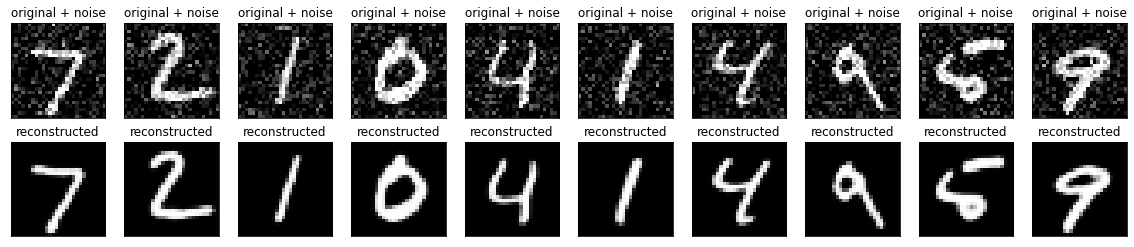

In [8]:
encoded_imgs = model.autoencoder.encoder(x_test).numpy()
decoded_imgs = model.autoencoder.decoder(encoded_imgs).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

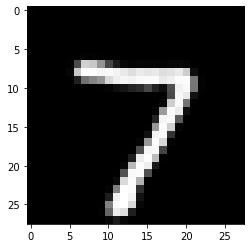

In [9]:
dc = model.encodingDecoding(x_test[0])
plt.imshow(tf.squeeze(dc))


In [10]:
model.trainClasificator()

Epoch 1/10
938/938 - 15s - loss: 0.3853 - accuracy: 0.8818 - val_loss: 0.1497 - val_accuracy: 0.9660
Epoch 2/10
938/938 - 13s - loss: 0.1002 - accuracy: 0.9715 - val_loss: 0.0530 - val_accuracy: 0.9874
Epoch 3/10
938/938 - 13s - loss: 0.0694 - accuracy: 0.9803 - val_loss: 0.0620 - val_accuracy: 0.9830
Epoch 4/10
938/938 - 13s - loss: 0.0574 - accuracy: 0.9841 - val_loss: 0.0602 - val_accuracy: 0.9837
Epoch 5/10
938/938 - 13s - loss: 0.0515 - accuracy: 0.9857 - val_loss: 0.0327 - val_accuracy: 0.9902
Epoch 6/10
938/938 - 13s - loss: 0.0469 - accuracy: 0.9865 - val_loss: 0.0365 - val_accuracy: 0.9893
Epoch 7/10
938/938 - 13s - loss: 0.0413 - accuracy: 0.9880 - val_loss: 0.0361 - val_accuracy: 0.9887
Epoch 8/10
938/938 - 13s - loss: 0.0378 - accuracy: 0.9891 - val_loss: 0.0466 - val_accuracy: 0.9870
Epoch 9/10
938/938 - 13s - loss: 0.0340 - accuracy: 0.9901 - val_loss: 0.0230 - val_accuracy: 0.9935
Epoch 10/10
938/938 - 13s - loss: 0.0322 - accuracy: 0.9908 - val_loss: 0.0311 - val_accura

In [11]:
dc.shape
a = tf.squeeze(dc)
a = tf.expand_dims(input=a,axis = 2)

pred = model.clasifierPredict(a)
pred

7